06-combine-two-mechanisms.ipynb
======================

In this section, we use the two tables from the previous sections to combine the two different mechanisms.

**Things to do**
* Test the results.
* Make code modular (create a function for plotting).

## Load packages and read tables.

In [1]:
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read a summary table of the victimisation-based mechanism.
PATH_TO_VIC_DATA = "s3://social-research-cheating/summary-tables/emp-net/vic_tab_30.parquet"
vic_data = spark.read.parquet(PATH_TO_VIC_DATA)
vic_data.registerTempTable("vic_data")

# Read a summary table of the observation-based mechanism.
PATH_TO_OBS_DATA = "s3://social-research-cheating/summary-tables/emp-net/sev_obs/obs_tab_30.parquet"
obs_data = spark.read.parquet(PATH_TO_OBS_DATA)
obs_data.registerTempTable("obs_data")

In [3]:
# Collect the transitions that happened within seven days after observing or being killed by cheating.
vic_tab = spark.sql("SELECT * FROM vic_data WHERE period <= 7")
obs_tab = spark.sql("SELECT * FROM obs_data WHERE period <= 7")

vic_tab.registerTempTable("vic_tab")
obs_tab.registerTempTable("obs_tab")

In [4]:
# Show the first few rows of each dataset.
vic_tab.show()
obs_tab.show()

obs_df = obs_tab.toPandas()
vic_df = vic_tab.toPandas()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.393b6ee09...|2019-03-08|2019-03-01|     7|        2|            1|           2|
|account.3f888b606...|2019-03-10|2019-03-05|     5|        7|            4|           7|
|account.4b6c650bd...|2019-03-15|2019-03-11|     4|        2|            0|           2|
|account.73e50018a...|2019-03-27|2019-03-20|     7|        1|            1|           1|
|account.b3e7bbe4a...|2019-03-09|2019-03-04|     5|        1|            0|           1|
|account.b9fc5f796...|2019-03-10|2019-03-04|     6|        1|            1|           1|
|account.d17f59ffc...|2019-03-26|2019-03-22|     4|        1|            0|           1|
|account.e03c68274...|2019-03-12|2019-03-07|     5|        2|            0|           2|
|account.052f9ab05...

## 1. Merge two tables.

In [5]:
# Create a table that contains player (cheater) IDs and the start dates of cheating adoption for each cheater
dates_obs = obs_df[['id', 'start_date']]
dates_vic = vic_df[['id', 'start_date']]
dates_df = pd.concat([dates_obs, dates_vic])
dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
dates_df = spark.createDataFrame(dates_df)
dates_df.registerTempTable("dates_df")
dates_df.show(10)

+--------------------+----------+
|                  id|start_date|
+--------------------+----------+
|account.0d0742d55...|2019-03-08|
|account.23195c2d9...|2019-03-10|
|account.28af418a3...|2019-03-11|
|account.39e686ad2...|2019-03-05|
|account.49a8333dc...|2019-03-02|
|account.4b7e55982...|2019-03-05|
|account.4f6aede74...|2019-03-11|
|account.52adde8ad...|2019-03-02|
|account.5473621c3...|2019-03-06|
|account.7e5a8f968...|2019-03-08|
+--------------------+----------+
only showing top 10 rows



In [6]:
add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                            CASE WHEN total_cheaters IS NULL THEN 0 ELSE total_cheaters END AS total_obs, 
                            CASE WHEN sev_cheaters IS NULL THEN 0 ELSE sev_cheaters END AS sev_obs 
                            FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
add_obs_info.registerTempTable("add_obs_info")

merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                         CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                         CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                         FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
merged_df.show(10)

+--------------------+----------+---------+-------+---------+-------+
|                  id|start_date|total_obs|sev_obs|total_exp|sev_exp|
+--------------------+----------+---------+-------+---------+-------+
|account.0d0742d55...|2019-03-08|        1|      1|        2|      1|
|account.23195c2d9...|2019-03-10|        0|      0|        0|      0|
|account.28af418a3...|2019-03-11|        0|      0|        1|      1|
|account.39e686ad2...|2019-03-05|        1|      1|        0|      0|
|account.49a8333dc...|2019-03-02|        1|      1|        0|      0|
|account.4b7e55982...|2019-03-05|        0|      0|        0|      0|
|account.4f6aede74...|2019-03-11|        0|      0|        0|      0|
|account.52adde8ad...|2019-03-02|        4|      4|        1|      0|
|account.5473621c3...|2019-03-06|        1|      1|        0|      0|
|account.7e5a8f968...|2019-03-08|        0|      0|        0|      0|
+--------------------+----------+---------+-------+---------+-------+
only showing top 10 

## 2. Plot the distribution of experiences and observations.

In [7]:
merged_tab = merged_df.toPandas()
pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
print(pairs_tab)
pairs_tab.to_csv('emp_tab_30.csv', index=False)

    total_obs  total_exp  freq
0           0          0   691
1           0          1   179
2           0          2    32
3           0          3    11
4           0          4     1
5           0          5     3
6           1          0   349
7           1          1   111
8           1          2    25
9           1          3     5
10          2          0   129
11          2          1    71
12          2          2    22
13          2          3     5
14          2          4     1
15          3          0    54
16          3          1    44
17          3          2    16
18          3          3     2
19          3          4     2
20          4          0    21
21          4          1    17
22          4          2    10
23          4          3     5
24          4          4     1
25          4          5     1
26          5          0     8
27          5          1    10
28          5          2     6
29          5          3     3
..        ...        ...   ...
32      

In [8]:
sev_pairs_tab = merged_tab.groupby(['sev_obs', 'sev_exp']).size().reset_index(name="freq")
print(sev_pairs_tab)
sev_pairs_tab.to_csv('sev_emp_tab_30.csv', index=False)

    sev_obs  sev_exp  freq
0         0        0   995
1         0        1    71
2         0        2     6
3         0        3     1
4         1        0   355
5         1        1    88
6         1        2     4
7         1        3     1
8         2        0   124
9         2        1    51
10        2        2     7
11        2        3     1
12        3        0    42
13        3        1    35
14        3        2     5
15        4        0    30
16        4        1    13
17        4        2     8
18        4        3     5
19        4        4     1
20        5        0     6
21        5        1     8
22        5        2     3
23        5        3     2
24        6        0     3
25        6        1     1
26        6        3     1
27        7        0     3
28        7        1     3
29        7        2     2
30        7        3     1
31        8        0     1
32        8        2     4
33        9        0     2
34        9        2     1
35        9        5     1
3

## 3. Create a merged data table for randomised networks.

In [10]:
for i in range(1, 4):
    # Read a summary table of the victimisation-based mechanism.
    vic_tab = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/vic_tab_" 
                                 + str(i) + ".parquet")
    vic_tab.registerTempTable("vic_tab")

    # Read a summary table of the observation-based mechanism.
    obs_tab = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/sev_obs/obs_tab_30_" 
                                 + str(i) + ".parquet")
    obs_tab.registerTempTable("obs_tab")
    
    obs_df = obs_tab.toPandas()
    vic_df = vic_tab.toPandas()
    
    dates_obs = obs_df[['id', 'start_date']]
    dates_vic = vic_df[['id', 'start_date']]
    dates_df = pd.concat([dates_obs, dates_vic])
    dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
    dates_df = spark.createDataFrame(dates_df)
    dates_df.registerTempTable("dates_df")
    
    add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                                CASE WHEN total_cheaters IS NULL THEN 0 ELSE total_cheaters END AS total_obs, 
                                CASE WHEN sev_cheaters IS NULL THEN 0 ELSE sev_cheaters END AS sev_obs 
                                FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
    add_obs_info.registerTempTable("add_obs_info")

    merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                             CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                             CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                             FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
    
    merged_tab = merged_df.toPandas()
    
    pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
    pairs_tab.to_csv('rand_tab_30_' + str(i) + '.csv', index=False)
    
    sev_pairs_tab = merged_tab.groupby(['sev_obs', 'sev_exp']).size().reset_index(name="freq")
    sev_pairs_tab.to_csv('sev_rand_tab_30_' + str(i) + '.csv', index=False)

In [45]:
# Read a summary table of the victimisation-based mechanism.
vic_tab = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/vic_tab_1.parquet")
vic_tab.registerTempTable("vic_tab")

# Read a summary table of the observation-based mechanism.
obs_tab = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/obs_tab_1.parquet")
obs_tab.registerTempTable("obs_tab")

# Show the first few rows of each dataset.
vic_tab.show()
obs_tab.show()

obs_df = obs_tab.toPandas()
vic_df = vic_tab.toPandas()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.e493e8036...|2019-03-02|2019-03-01|     1|        2|            0|           2|
|account.47ff35eca...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.52adde8ad...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.272b33c63...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.8c52a3348...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.d2cb5110d...|2019-03-03|2019-03-01|     2|        1|            0|           1|
|account.6825517dd...|2019-03-02|2019-03-01|     1|        2|            0|           1|
|account.70eb95960...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.c3d862798...

In [46]:
# Create a table that contains player (cheater) IDs and the start dates of cheating adoption for each cheater
dates_obs = obs_df[['id', 'start_date']]
dates_vic = vic_df[['id', 'start_date']]
dates_df = pd.concat([dates_obs, dates_vic])
dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
dates_df = spark.createDataFrame(dates_df)
dates_df.registerTempTable("dates_df")
dates_df.show(10)

+--------------------+----------+
|                  id|start_date|
+--------------------+----------+
|account.090ca369b...|2019-03-02|
|account.272b33c63...|2019-03-02|
|account.da692c372...|2019-03-02|
|account.8d69e3520...|2019-03-02|
|account.11dbd81ee...|2019-03-02|
|account.da1a6fa0b...|2019-03-02|
|account.27478c512...|2019-03-02|
|account.e493e8036...|2019-03-02|
|account.71aea180f...|2019-03-02|
|account.ab15ceb31...|2019-03-02|
+--------------------+----------+
only showing top 10 rows



In [47]:
add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                            CASE WHEN total_obs IS NULL THEN 0 ELSE total_obs END AS total_obs, 
                            CASE WHEN total_sev_dam IS NULL THEN 0 ELSE total_sev_dam END AS sev_obs 
                            FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
add_obs_info.registerTempTable("add_obs_info")

merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                         CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                         CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                         FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
merged_df.show(10)

+--------------------+----------+---------+-------+---------+-------+
|                  id|start_date|total_obs|sev_obs|total_exp|sev_exp|
+--------------------+----------+---------+-------+---------+-------+
|account.090ca369b...|2019-03-02|        3|      0|        0|      0|
|account.272b33c63...|2019-03-02|        9|      0|        1|      0|
|account.da692c372...|2019-03-02|        8|      1|        0|      0|
|account.8d69e3520...|2019-03-02|       41|     20|        0|      0|
|account.11dbd81ee...|2019-03-02|        9|      1|        0|      0|
|account.da1a6fa0b...|2019-03-02|       17|      3|        0|      0|
|account.27478c512...|2019-03-02|       31|     10|        0|      0|
|account.e493e8036...|2019-03-02|       23|      0|        2|      0|
|account.71aea180f...|2019-03-02|        3|      3|        0|      0|
|account.ab15ceb31...|2019-03-02|        1|      0|        0|      0|
+--------------------+----------+---------+-------+---------+-------+
only showing top 10 

In [48]:
merged_tab = merged_df.toPandas()
pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
pairs_tab.to_csv('rand_tab_1.csv', index=False)

    total_obs  total_exp  freq
0           1          0     2
1           1          1     1
2           2          0     2
3           3          0     7
4           4          0     4
5           5          0     1
6           6          0     2
7           7          0     1
8           8          0     2
9           9          0     2
10          9          1     1
11         10          1     1
12         10          2     1
13         11          0     1
14         13          0     1
15         15          0     1
16         16          0     1
17         17          0     2
18         17          1     1
19         18          0     3
20         19          0     2
21         19          1     1
22         20          0     1
23         21          0     1
24         21          1     1
25         23          2     1
26         27          1     1
27         29          0     1
28         31          0     1
29         32          0     1
30         34          0     1
31      

In [49]:
sev_pairs_tab = merged_tab.groupby(['sev_obs', 'sev_exp']).size().reset_index(name="freq")
print(sev_pairs_tab)
sev_pairs_tab.to_csv('sev_emp_tab_1.csv', index=False)

    sev_obs  sev_exp  freq
0         0        0    17
1         1        0     3
2         2        0     2
3         3        0     9
4         4        0     2
5         5        0     1
6         5        1     1
7         7        0     2
8         9        0     2
9         9        1     1
10       10        0     1
11       11        0     1
12       12        0     2
13       14        1     1
14       15        0     1
15       17        0     1
16       19        0     1
17       20        0     2
18       23        0     1
19       60        0     1


## 4. Create a heatmap.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors

In [9]:
data = pd.read_csv("data/emp_tab.csv")
data = data.rename(columns={'freq': 'emp_freq'})
print(data[:5])

   total_obs  total_exp  emp_freq
0          0          0       372
1          0          1       121
2          0          2        23
3          0          3         9
4          0          4         1


In [10]:
rand_dat = pd.read_csv("data/rand_tab_1.csv")
merged_df = pd.merge(data, rand_dat, on=['total_obs','total_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
merged_df = merged_df.rename(columns={'freq': 'rand_freq_1'})

for i in range(2, 6):
    rand_dat = pd.read_csv("data/rand_tab_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','total_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
    merged_df = merged_df.rename(columns={'freq': 'rand_freq_' + str(i)})

# Remove the first row.
merged_df = merged_df.iloc[1:]
print(merged_df[:5])

   total_obs  total_exp  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3  \
1          0          1     121.0         55.0         62.0         64.0   
2          0          2      23.0          1.0          0.0          2.0   
3          0          3       9.0          0.0          0.0          0.0   
4          0          4       1.0          0.0          0.0          0.0   
5          0          5       3.0          0.0          0.0          0.0   

   rand_freq_4  rand_freq_5  
1         57.0         58.0  
2          1.0          1.0  
3          0.0          1.0  
4          0.0          0.0  
5          0.0          0.0  


In [11]:
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)
merged_df = merged_df.drop(merged_df[merged_df.total_exp > 10].index)
print(merged_df)

     total_obs  total_exp  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3  \
1            0          1     121.0         55.0         62.0         64.0   
2            0          2      23.0          1.0          0.0          2.0   
3            0          3       9.0          0.0          0.0          0.0   
4            0          4       1.0          0.0          0.0          0.0   
5            0          5       3.0          0.0          0.0          0.0   
6            1          0     414.0        559.0        550.0        545.0   
7            1          1      77.0        115.0        122.0        113.0   
8            1          2       6.0         16.0         14.0         10.0   
9            1          3       2.0          0.0          2.0          2.0   
10           2          0     210.0        277.0        260.0        300.0   
11           2          1      58.0         91.0         92.0         94.0   
12           2          2      13.0         15.0         22.0   

In [12]:
# Test a heatmap using the small dataset (with the results from three randomised networks and one empirical network).
test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
print(test_dat)

     total_obs  total_exp  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3  \
0            1          0     414.0        559.0        550.0        545.0   
1            2          0     210.0        277.0        260.0        300.0   
2            3          0     110.0        159.0        145.0        138.0   
3            4          0      60.0         80.0         89.0         79.0   
4            5          0      40.0         39.0         42.0         48.0   
5            6          0      21.0         24.0         33.0         25.0   
6            7          0      15.0         12.0         14.0         16.0   
7            8          0       5.0         12.0         18.0         13.0   
8            9          0       4.0         12.0          2.0         12.0   
9           10          0       1.0          5.0          2.0          1.0   
10          11          0       2.0          2.0          2.0          4.0   
11          12          0       2.0          0.0          2.0   

In [13]:
test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['rand_std'] = test_dat.iloc[:, 3:].std(axis=1)

test_dat['observed_stat'] = (test_dat['emp_freq'] - test_dat['rand_mean']) / test_dat['rand_std']
test_dat = test_dat.round({"rand_mean":2, "rand_std":2, "observed_stat":2})
test_dat = test_dat.replace([np.inf, -np.inf], np.nan)
piv = pd.pivot_table(test_dat, values="observed_stat",index=["total_exp"], columns=["total_obs"])
print(piv)

total_obs     0      1     2     3     4     5     6     7     8     9   ...  \
total_exp                                                                ...   
0            NaN -17.33 -5.20 -5.32 -3.63 -0.78 -2.06  0.15 -4.46 -1.24  ...   
1          18.67  -3.40 -8.31 -1.79 -4.90 -2.40 -3.11 -2.33 -2.44 -2.75  ...   
2          34.79  -2.49 -2.00 -1.77 -1.98 -2.90  0.41 -4.50 -5.43 -2.68  ...   
3          22.00  -0.15 -1.79  1.17 -1.50 -1.25 -1.81 -1.41 -2.12 -1.25  ...   
4            NaN    NaN -0.50 -0.82  0.00 -1.22 -0.79  0.27 -1.28 -1.38  ...   
5            NaN    NaN   NaN   NaN   NaN -1.22 -1.22 -1.58  1.22  1.22  ...   
6            NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
7            NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

total_obs    11    12    13    14    15    16    17    18    19    20  
total_exp                                                              
0         -0.82  1.07 -0.50 -0.20 -1.07  1.22  2.00 -1.

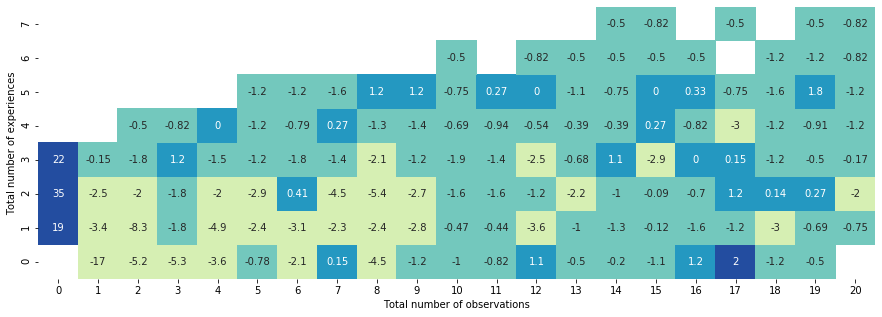

In [14]:
# Plot a heatmap (obs >= 5).
num_of_bins = 4  # Discretizes the interpolation into bins
ran = [-np.inf, -1.96, 0, 1.96, np.inf]

fig = plt.figure(figsize=(15, 5))
cmap = sns.color_palette("YlGnBu", num_of_bins)
norm = matplotlib.colors.BoundaryNorm(ran, len(ran))
ax = sns.heatmap(piv, cmap=cmap, annot=True, norm=norm, cbar=False)
ax.invert_yaxis()
# colorbar = ax.collections[0].colorbar
plt.xlabel('Total number of observations')
plt.ylabel('Total number of experiences')
plt.show()
fig.savefig('total_plot.png')

In [15]:
data = pd.read_csv("data/sev_emp_tab.csv")
data = data.rename(columns={'freq': 'emp_freq'})

rand_dat = pd.read_csv("data/sev_rand_tab_1.csv")
merged_df = pd.merge(data, rand_dat, on=['sev_obs','sev_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['sev_obs','sev_exp'])
merged_df = merged_df.rename(columns={'freq': 'rand_freq_1'})

for i in range(2, 6):
    rand_dat = pd.read_csv("data/sev_rand_tab_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['sev_obs','sev_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['sev_obs','sev_exp'])
    merged_df = merged_df.rename(columns={'freq': 'rand_freq_' + str(i)})

# Remove the first row.
merged_df = merged_df.iloc[1:]
merged_df = merged_df.drop(merged_df[merged_df.sev_obs > 20].index)
merged_df = merged_df.drop(merged_df[merged_df.sev_exp > 10].index)
print(merged_df)

     sev_obs  sev_exp  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3  \
1          0        1      48.0         13.0          7.0         10.0   
2          0        2       4.0          0.0          0.0          0.0   
3          0        3       1.0          0.0          0.0          0.0   
4          1        0     423.0        570.0        577.0        578.0   
5          1        1      65.0         98.0        110.0         85.0   
6          1        2       0.0          2.0          4.0          1.0   
7          2        0     187.0        260.0        251.0        284.0   
8          2        1      47.0         76.0         65.0         69.0   
9          2        2       7.0          3.0          8.0          7.0   
10         2        3       0.0          0.0          1.0          0.0   
11         3        0      89.0        138.0        117.0        126.0   
12         3        1      41.0         57.0         52.0         55.0   
13         3        2       3.0       

In [16]:
# Create a heatmap using killings and observations with high level of harm.
test_sev_dat = merged_df.sort_values(['sev_exp', 'sev_obs']).reset_index(drop=True)
test_sev_dat['rand_mean'] = test_sev_dat.iloc[:, 3:].mean(axis=1)
test_sev_dat['rand_std'] = test_sev_dat.iloc[:, 3:].std(axis=1)

test_sev_dat['observed_stat'] = (test_sev_dat['emp_freq'] - test_sev_dat['rand_mean']) / test_sev_dat['rand_std']
test_sev_dat = test_sev_dat.round({"rand_mean":2, "rand_std":2, "observed_stat":2})

test_sev_dat = test_sev_dat.replace([np.inf, -np.inf], np.nan)

piv = pd.pivot_table(test_sev_dat, values="observed_stat",index=["sev_exp"], columns=["sev_obs"])
print(piv)

sev_obs    0      1     2     3     4     5     6     7     8     9   ...  \
sev_exp                                                               ...   
0         NaN -27.58 -6.84 -4.70 -5.03 -5.38 -5.59 -3.05 -1.17 -0.59  ...   
1        4.52  -1.65 -6.26 -2.18 -6.37 -3.41 -3.65 -0.80 -0.85 -1.94  ...   
2        9.50  -1.91  0.34 -2.54 -2.97 -3.16 -2.22 -1.20 -5.75 -1.33  ...   
3         NaN    NaN -0.50 -0.82  0.00 -1.22  3.74 -1.54  0.00  1.58  ...   
4         NaN    NaN   NaN   NaN   NaN -0.50 -0.50 -0.50 -0.82   NaN  ...   
5         NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN -0.50  ...   

sev_obs    11    12    13    14    15    16    17    18   19    20  
sev_exp                                                             
0       -1.31 -0.50   NaN -1.22 -0.91  0.50 -1.57 -1.22  NaN -0.82  
1       -3.33 -9.50 -1.77 -1.75 -1.36 -0.82   NaN -1.22 -0.5 -0.82  
2        0.29 -2.25  0.00  3.27  0.00 -0.82 -0.82 -1.07 -0.5 -1.22  
3       -1.22 -1.12 -1.03  0.27 -0.75 

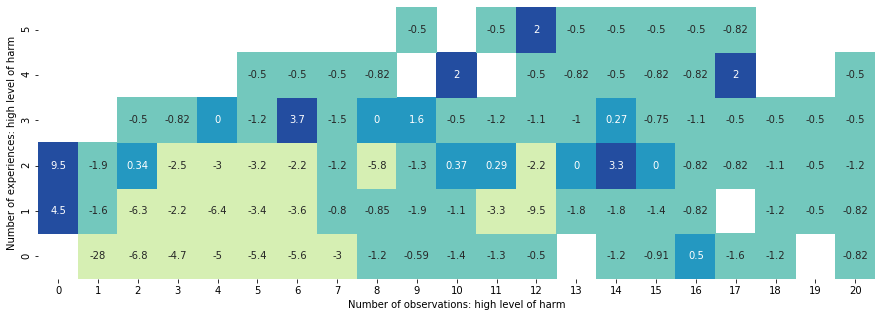

In [17]:
# obs >= 5
num_of_bins = 4  # Discretizes the interpolation into bins
ran = [-np.inf, -1.96, 0, 1.96, np.inf]

fig = plt.figure(figsize=(15, 5))
cmap = sns.color_palette("YlGnBu", num_of_bins)
norm = matplotlib.colors.BoundaryNorm(ran, len(ran))
ax = sns.heatmap(piv, cmap=cmap, annot=True, norm=norm, cbar=False)
ax.invert_yaxis()
# colorbar = ax.collections[0].colorbar
plt.xlabel('Number of observations: high level of harm')
plt.ylabel('Number of experiences: high level of harm')
plt.show()
# fig.savefig('plot.png')